# Roteiro de trabalho

Tempos dos vídeos

(IT) Insulina Tradicional (15:00) 
 900 segundos
 
(GT) Glucagon Tradicional (14:57) 
 897 segundos

(IA) Insulina Ativa (19:26) 
 1166 segundos

(GA) Glucagon Ativa (20:43) 
 1243 segundos
 
Participante deste roteiro:
Murilo: GT e IA

In [2]:
# imports de bibliotecas

import numpy as np
import mne
from scipy.signal import welch
import matplotlib.pyplot as plt

In [3]:
# definição do info (MNE)

n_channels = 8
ch_types = ['eeg'] * n_channels
sfreq = 250
ch_names = ["F3", "Fz", "F4", "C3", "Cz", "C4", "P3", "P4"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage("standard_1020")

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [4]:

# Carregamento e organização dos dados do Murilo

# Glucagon Tradicional
gt = ['../dataset/s5/gT/OpenBCI-RAW-2023-09-26_18-50-25.txt']
gt_ob = [np.loadtxt(txt, delimiter=',', skiprows=5, usecols=range(1, 9)) for txt in gt]
data_gt = gt_ob[0][68550:278550, :]  # Acessa o primeiro elemento da lista e então faz o fatiamento

# Teste Final
teste_final = ['../dataset/s5/tF/OpenBCI-RAW-2023-11-06_19-56-20.txt']
teste_final_ob = [np.loadtxt(txt, delimiter=',', skiprows=5, usecols=range(1, 9)) for txt in teste_final]
data_teste = teste_final_ob[0][37350:211050, :]  # Acessa o primeiro elemento da lista e então faz o fatiamento
data_basal = teste_final_ob[0][21150:36150, :]  # Acessa o primeiro elemento da lista e então faz o fatiamento

# Criar o RawArray
X = {
    'gt': mne.io.RawArray(data_gt.T, info),  # Usando a forma (n_channels, n_samples)
    'test_final': mne.io.RawArray(data_teste.T, info)  # Usando a forma (n_channels, n_samples)
}



Creating RawArray with float64 data, n_channels=8, n_times=210000
    Range : 0 ... 209999 =      0.000 ...   839.996 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=171653
    Range : 0 ... 171652 =      0.000 ...   686.608 secs
Ready.


In [5]:
# filtragem de todos os dados

for key in X:
    X[key].notch_filter(freqs=60)
    X[key].filter(l_freq=4, h_freq=100)
    

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 413 samples (1.652 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband

In [6]:
print(X['gt'].n_times)
print(X['test_final'].n_times)

210000
171653


In [7]:
print(X['gt'].times[-1])
print(X['test_final'].times[-1])

839.996
686.608


In [8]:
import numpy as np

sr = 250            # taxa de amostragem
jump = 5            # 5 segundos de buffer
size = sr * jump    # quantidade de pontos avaliados

# Definir os limites das bandas de frequência (em Hz)
theta_band = (4, 8)       # Theta: 4 - 8 Hz
alpha_band = (8, 13)      # Alpha: 8 - 13 Hz
beta_band = (13, 30)      # Beta: 13 - 30 Hz
gamma_band = (30, 100)    # Gamma: 30 - 100 Hz

total_pc = {}
data_names = ('gt', 'teste_final')

# Certifique-se de que os dados foram carregados corretamente
datas = [X['gt'], X['test_final']]  # Corrigido para usar diretamente X['test_final']

for k, data in enumerate(datas):
    results = [0, 0, 0, 0]
    for i in range(0, data.n_times, 250):
        if i + size < data.n_times:
            cut = data.copy().crop(tmin=data.times[i], tmax=data.times[i]+jump)
        else:
            cut = data.copy().crop(tmin=data.times[i], tmax=data.times[-1])  
        
        # Número de pontos por segmento
        nperseg = 128
        # Quantidade de sobreposição entre segmentos
        noverlap = nperseg // 2
        
        cut.set_eeg_reference(ref_channels='average')
        cut_data = cut.get_data()  # Dados do segmento cortado

        # Calculando a média dos 8 eletrodos
        freqs, psd = welch(cut_data, fs=sr, nperseg=nperseg, noverlap=noverlap)
        psd_avg = np.average(psd, axis=0)

        # Encontrar os índices correspondentes às frequências de interesse
        theta_idxs = np.where((freqs >= theta_band[0]) & (freqs <= theta_band[1]))[0]
        alpha_idxs = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]
        beta_idxs = np.where((freqs >= beta_band[0]) & (freqs <= beta_band[1]))[0]
        gamma_idxs = np.where((freqs >= gamma_band[0]) & (freqs <= gamma_band[1]))[0]
    
        # Calcular a potência em cada banda de frequência por meio da integração da PSD
        bands = [np.sum(psd_avg[theta_idxs]), np.sum(psd_avg[alpha_idxs]), np.sum(psd_avg[beta_idxs]), np.sum(psd_avg[gamma_idxs])]
        # Calculando a pontuação de cada banda para mostrar a porcentagem futura
        results[np.argmax(bands)] += 1

    total = sum(results)
    percentages = [round((count/total) * 100, 2) for count in results]
    print(data.__str__())
    total_pc[data_names[k]] = percentages

print(total_pc)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
E

In [9]:
from matplotlib import rcParams

rcParams['figure.figsize'] = [6., 4.]

def plot_bar(x):
    colors = ('orange', 'green', 'blue', 'purple')
    bars = plt.bar(('theta', 'alpha', 'beta', 'gamma'), x, color=colors)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
    plt.title('Porcentagem da potência em cada banda de frequência')
    plt.xlabel('Banda de Frequência')
    plt.ylabel('Porcentagem durante a atividade')

    # Exibir o gráfico
    plt.show()

# Aplicando os valores das porcentagens obtidas na função do grafico

Glucagon Tradicional


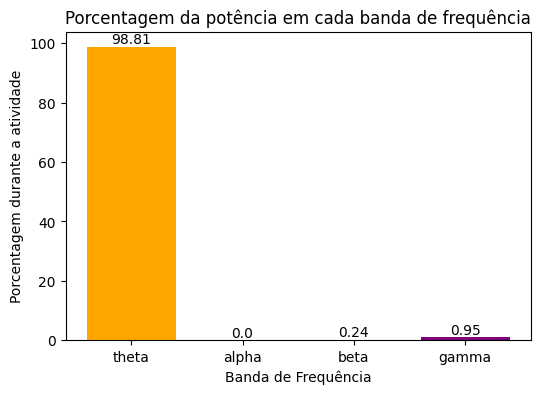

Teste Final


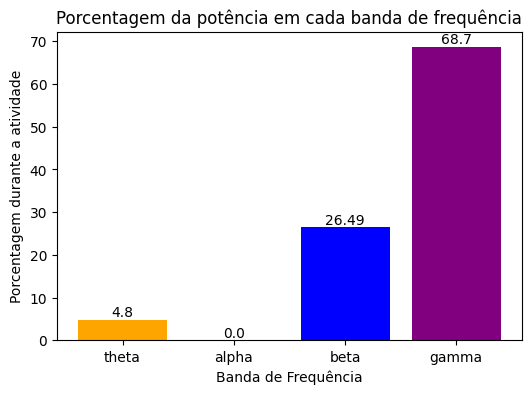

In [11]:
print('Glucagon Tradicional')
plot_bar(total_pc['gt'])
print('Teste Final')
plot_bar(total_pc['teste_final'])